In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_one_cnn(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def one_by_three_cnn(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_pool(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = MaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = MaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = MaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = MaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
convBlocks = 2

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

preprocess = one_by_one_cnn(300, embedding_dropout)
preprocess = one_by_one_cnn(300, preprocess)

block = preprocess
for currentBlock in range(convBlocks):
  filters = 128 * (2 + currentBlock)
  block = one_by_three_cnn(filters, block)
  if(currentBlock < convBlocks-1):
    block = yoon_kim_pool(filters, block)
  
features = yoon_kim_feature_extractor(512, block)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 10:45 - loss: 0.1866 - acc: 0.9276

102112/102124 [============================>.] - ETA: 0s - loss: 0.0921 - acc: 0.9662

102124/102124 [==============================] - 841s 8ms/step - loss: 0.0921 - acc: 0.9662 - val_loss: 0.0492 - val_acc: 0.9817
Epoch 2/32
 10144/102124 [=>............................] - ETA: 11:45 - loss: 0.0610 - acc: 0.9783

102112/102124 [============================>.] - ETA: 0s - loss: 0.0598 - acc: 0.9782

102124/102124 [==============================] - 833s 8ms/step - loss: 0.0598 - acc: 0.9782 - val_loss: 0.0488 - val_acc: 0.9818
roc-auc: 0.9758 - roc-auc_val: 0.9746                                                                                                    
Epoch 3/32
  8672/102124 [=>............................] - ETA: 11:50 - loss: 0.0557 - acc: 0.9796

102112/102124 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9796

102124/102124 [==============================] - 834s 8ms/step - loss: 0.0555 - acc: 0.9796 - val_loss: 0.0469 - val_acc: 0.9825
Epoch 4/32
 10144/102124 [=>............................] - ETA: 11:49 - loss: 0.0540 - acc: 0.9798

102112/102124 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9803

102124/102124 [==============================] - 834s 8ms/step - loss: 0.0530 - acc: 0.9803 - val_loss: 0.0478 - val_acc: 0.9819
roc-auc: 0.9795 - roc-auc_val: 0.9747                                                                                                    
Epoch 5/32
  8672/102124 [=>............................] - ETA: 11:50 - loss: 0.0516 - acc: 0.9801

102112/102124 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9810

102124/102124 [==============================] - 834s 8ms/step - loss: 0.0512 - acc: 0.9810 - val_loss: 0.0450 - val_acc: 0.9828
Epoch 6/32
 10144/102124 [=>............................] - ETA: 11:43 - loss: 0.0482 - acc: 0.9820

102112/102124 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9814

102124/102124 [==============================] - 836s 8ms/step - loss: 0.0497 - acc: 0.9814 - val_loss: 0.0446 - val_acc: 0.9828
roc-auc: 0.9821 - roc-auc_val: 0.9773                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 11:49 - loss: 0.0482 - acc: 0.9815

102112/102124 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9818

102124/102124 [==============================] - 833s 8ms/step - loss: 0.0486 - acc: 0.9818 - val_loss: 0.0437 - val_acc: 0.9832
Epoch 8/32
 10144/102124 [=>............................] - ETA: 11:46 - loss: 0.0476 - acc: 0.9819

102112/102124 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9821

102124/102124 [==============================] - 833s 8ms/step - loss: 0.0474 - acc: 0.9821 - val_loss: 0.0440 - val_acc: 0.9831
roc-auc: 0.9802 - roc-auc_val: 0.9784                                                                                                    
Epoch 9/32
  8672/102124 [=>............................] - ETA: 11:49 - loss: 0.0478 - acc: 0.9816

102112/102124 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9822

102124/102124 [==============================] - 836s 8ms/step - loss: 0.0469 - acc: 0.9822 - val_loss: 0.0446 - val_acc: 0.9825

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00021763764380011708.
Epoch 10/32
  7968/102124 [=>............................] - ETA: 12:04 - loss: 0.0467 - acc: 0.9818

102112/102124 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9822

102124/102124 [==============================] - 829s 8ms/step - loss: 0.0459 - acc: 0.9822 - val_loss: 0.0432 - val_acc: 0.9830
roc-auc: 0.9875 - roc-auc_val: 0.981                                                                                                    
Epoch 11/32
  8672/102124 [=>............................] - ETA: 11:50 - loss: 0.0466 - acc: 0.9818

102112/102124 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9828

102124/102124 [==============================] - 832s 8ms/step - loss: 0.0450 - acc: 0.9828 - val_loss: 0.0420 - val_acc: 0.9838
Epoch 12/32
 10112/102124 [=>............................] - ETA: 11:42 - loss: 0.0434 - acc: 0.9834

102112/102124 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9830

102124/102124 [==============================] - 834s 8ms/step - loss: 0.0443 - acc: 0.9830 - val_loss: 0.0414 - val_acc: 0.9842
roc-auc: 0.9885 - roc-auc_val: 0.982                                                                                                    
Epoch 13/32
  8672/102124 [=>............................] - ETA: 11:48 - loss: 0.0422 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0433 - acc: 0.9833

102124/102124 [==============================] - 831s 8ms/step - loss: 0.0433 - acc: 0.9833 - val_loss: 0.0415 - val_acc: 0.9838
Epoch 14/32
 10112/102124 [=>............................] - ETA: 11:35 - loss: 0.0406 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9836

102124/102124 [==============================] - 834s 8ms/step - loss: 0.0427 - acc: 0.9836 - val_loss: 0.0410 - val_acc: 0.9843
roc-auc: 0.9894 - roc-auc_val: 0.982                                                                                                    
Epoch 15/32
  8672/102124 [=>............................] - ETA: 11:55 - loss: 0.0440 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9835

102124/102124 [==============================] - 835s 8ms/step - loss: 0.0424 - acc: 0.9835 - val_loss: 0.0409 - val_acc: 0.9845
Epoch 16/32
 10112/102124 [=>............................] - ETA: 11:35 - loss: 0.0403 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9838

102124/102124 [==============================] - 832s 8ms/step - loss: 0.0418 - acc: 0.9838 - val_loss: 0.0411 - val_acc: 0.9843
roc-auc: 0.9903 - roc-auc_val: 0.9826                                                                                                    
Epoch 17/32
  8672/102124 [=>............................] - ETA: 11:49 - loss: 0.0412 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9840

102124/102124 [==============================] - 835s 8ms/step - loss: 0.0412 - acc: 0.9840 - val_loss: 0.0407 - val_acc: 0.9845
Epoch 18/32
 10112/102124 [=>............................] - ETA: 11:34 - loss: 0.0410 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9839

102124/102124 [==============================] - 832s 8ms/step - loss: 0.0409 - acc: 0.9839 - val_loss: 0.0402 - val_acc: 0.9846
roc-auc: 0.9909 - roc-auc_val: 0.9836                                                                                                    
Epoch 19/32
  8672/102124 [=>............................] - ETA: 11:49 - loss: 0.0431 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9841

102124/102124 [==============================] - 836s 8ms/step - loss: 0.0408 - acc: 0.9841 - val_loss: 0.0401 - val_acc: 0.9846
Epoch 20/32
 10112/102124 [=>............................] - ETA: 11:33 - loss: 0.0399 - acc: 0.9847

102112/102124 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9842

102124/102124 [==============================] - 833s 8ms/step - loss: 0.0401 - acc: 0.9842 - val_loss: 0.0403 - val_acc: 0.9847
roc-auc: 0.9914 - roc-auc_val: 0.9832                                                                                                    
Epoch 21/32
  8672/102124 [=>............................] - ETA: 11:58 - loss: 0.0406 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9842

102124/102124 [==============================] - 833s 8ms/step - loss: 0.0398 - acc: 0.9842 - val_loss: 0.0407 - val_acc: 0.9843

Epoch 00021: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
  8032/102124 [=>............................] - ETA: 11:59 - loss: 0.0396 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9845

102124/102124 [==============================] - 833s 8ms/step - loss: 0.0392 - acc: 0.9845 - val_loss: 0.0408 - val_acc: 0.9843
roc-auc: 0.9916 - roc-auc_val: 0.9834                                                                                                    
Epoch 23/32
  8672/102124 [=>............................] - ETA: 11:59 - loss: 0.0376 - acc: 0.9847

102112/102124 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9845

102124/102124 [==============================] - 834s 8ms/step - loss: 0.0391 - acc: 0.9845 - val_loss: 0.0400 - val_acc: 0.9847
Epoch 24/32
 10112/102124 [=>............................] - ETA: 11:37 - loss: 0.0385 - acc: 0.9853

102112/102124 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9847

102124/102124 [==============================] - 833s 8ms/step - loss: 0.0387 - acc: 0.9847 - val_loss: 0.0402 - val_acc: 0.9846
roc-auc: 0.9917 - roc-auc_val: 0.9839                                                                                                    
Epoch 25/32
  8672/102124 [=>............................] - ETA: 11:45 - loss: 0.0397 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9848

102124/102124 [==============================] - 831s 8ms/step - loss: 0.0385 - acc: 0.9848 - val_loss: 0.0409 - val_acc: 0.9846
Epoch 26/32
 10112/102124 [=>............................] - ETA: 11:40 - loss: 0.0401 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9848

102124/102124 [==============================] - 834s 8ms/step - loss: 0.0384 - acc: 0.9848 - val_loss: 0.0401 - val_acc: 0.9846
roc-auc: 0.9923 - roc-auc_val: 0.9837                                                                                                    
Epoch 27/32
  8672/102124 [=>............................] - ETA: 11:49 - loss: 0.0365 - acc: 0.9854

102112/102124 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9849

102124/102124 [==============================] - 832s 8ms/step - loss: 0.0384 - acc: 0.9849 - val_loss: 0.0402 - val_acc: 0.9847
Epoch 28/32
 10112/102124 [=>............................] - ETA: 11:46 - loss: 0.0379 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9848

102124/102124 [==============================] - 833s 8ms/step - loss: 0.0381 - acc: 0.9848 - val_loss: 0.0402 - val_acc: 0.9847
roc-auc: 0.9927 - roc-auc_val: 0.9836                                                                                                    
Epoch 29/32
  8672/102124 [=>............................] - ETA: 11:49 - loss: 0.0372 - acc: 0.9858

102112/102124 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9849

102124/102124 [==============================] - 833s 8ms/step - loss: 0.0380 - acc: 0.9849 - val_loss: 0.0403 - val_acc: 0.9844
Epoch 30/32
 10112/102124 [=>............................] - ETA: 11:42 - loss: 0.0361 - acc: 0.9860

102112/102124 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9851

102124/102124 [==============================] - 832s 8ms/step - loss: 0.0379 - acc: 0.9851 - val_loss: 0.0405 - val_acc: 0.9846
roc-auc: 0.9929 - roc-auc_val: 0.9836                                                                                                    
Epoch 31/32
  8672/102124 [=>............................] - ETA: 11:50 - loss: 0.0376 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9850

102124/102124 [==============================] - 833s 8ms/step - loss: 0.0374 - acc: 0.9850 - val_loss: 0.0406 - val_acc: 0.9847
Epoch 32/32
 10112/102124 [=>............................] - ETA: 11:34 - loss: 0.0365 - acc: 0.9854

102112/102124 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9851

102124/102124 [==============================] - 834s 8ms/step - loss: 0.0375 - acc: 0.9851 - val_loss: 0.0405 - val_acc: 0.9847

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.9915009033866227e-05.
roc-auc: 0.9919 - roc-auc_val: 0.9836                                                                                                    


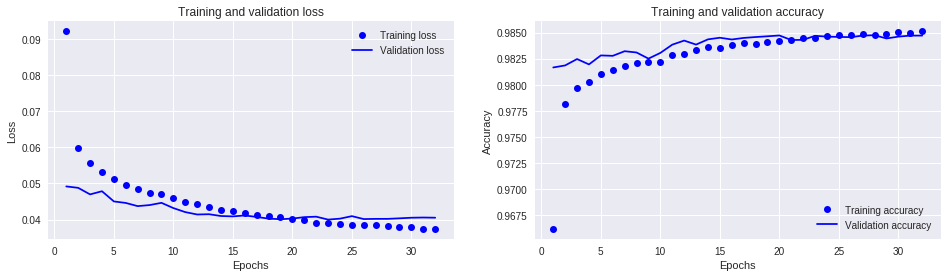

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 74s 2ms/step
([0.039213243554667696, 0.9849025911827661], 0.9876013555038167)
